Suzuki model for solid solution hardening in BCC alloy.

https://doi.org/10.1016/j.actamat.2019.02.013

In [5]:
from sympy import *
import numpy as np
import math
import sympy
import matplotlib.pyplot as plt
from IPython.display import clear_output
from random import randrange

In [152]:
class rao_model():
    def __init__(self, mu, b, E, c, k, T, v, epsilon, u, k_, comment='None'):
        super(rao_model, self).__init__()
        self.mu = mu
        self.b = b
        self.E = E
        self.c = c
        self.k = k 
        self.T = T
        self.a = 0.942*b 
        self.lamda = 10*b 
        self.v = v
        self.epsilon = epsilon 
        self.u = u
        self.k_ = k_
        self.comment = comment

    def softmax(self, x):
        f_x = np.exp(x) / np.sum(np.exp(x))
        return f_x

    def f1(self):
        tao_chose_list = []
        for index in range(len(self.c)):
            mu_, c_, E_ = self.mu, self.c, self.E
            tao_k = Symbol('tao_k', real=True)
            #*deltaV
            v_lefttop = 3*(self.k_**2)*(self.E[index]**2)*self.c[index]
            v_leftbot = 2*(tao_k**2)*self.a*(self.b**2)
            v_righttop = tao_k**2*(self.a**3)*(self.b**4)*(self.lamda**2)
            v_rightbot = 6*(self.k_**2)*(self.E[index]**2)*self.c[index]

            v_ = v_lefttop/v_leftbot + v_righttop/v_rightbot

            #*S
            s_lefttop = 18*(self.k_**2)*(self.E[index]**2)*self.c[index]*self.k*self.T
            s_leftbot = self.a**3*(self.b**4)*(self.lamda**2)
            s_righttop = (5*math.pi*self.k*self.T)**2*self.v*self.a*self.b
            s_rightbot = (self.mu[index]*self.b*v_)**2*self.epsilon

            s_ = s_lefttop/s_leftbot*sympy.log(s_righttop/s_rightbot)

            #*R
            r_top = 27*(self.k_**4)*(self.E[index]**4)*(self.c[index]**2)
            r_bot = (self.a**4)*(self.b**6)*(self.lamda**2)

            r_ = r_top/r_bot

            #*tao_k
            f1_ = tao_k**4 + s_*tao_k - r_
            res_list, tao_list = [], []
            # tao_k_c = 2e8
            # temp = 1e7
            # speed = 1e7
            # step = 0

            # while True:
            #     # tao_k_c = np.clip(tao_k_c, 1e7, 1e9)
            #     f1_res = abs(f1_.subs(tao_k, tao_k_c))
            #     res_list.append(abs(f1_res.evalf()))
            #     tao_list.append(tao_k_c)
            #     tao_chose = tao_k_c
            #     tao_chose += (np.random.rand()-0.5)*speed
            #     f1_res_ = abs(f1_.subs(tao_k, tao_chose))
            #     res = (f1_res - f1_res_).evalf()

            #     accep = np.random.rand()
            #     prob_ = np.min([1, exp(res/temp)])
            #     if accep <= prob_:
            #         tao_k_c = tao_chose

            #     temp /= 1.001
            #     speed /= 1.001

            #     if step % 100 == 0:
            #         clear_output(True)

            #         fig, (ax1, ax2) = plt.subplots(1, 2)
            #         ax1.plot(res_list)
            #         ax1.set_ylim([1e7, 1e9])
            #         ax2.plot(tao_list)
            #         plt.suptitle(f'Num steps: {step}, Minimum res: {f1_res}\n{tao_chose/1e6} MPa')
            #         plt.suptitle(f'Num steps: {step}, Minimum res: {np.min(res_list)}\n{tao_chose/1e6} MPa')
            #         plt.show()

            #     step += 1
            #     if step >= 5000:
            #         tao_chose_list.append(tao_chose)
            #         break

            for tao_k_c in np.linspace(1e6, 1e9, 2000):
                f1_res = abs(f1_.subs(tao_k, tao_k_c))
                res_list.append(f1_res.evalf())
                tao_list.append(tao_k_c)

            tao_chose_list.append(tao_list[np.argmin(res_list)])

        return np.array(tao_chose_list)

    def f4(self):
        j_list = []
        for index in range(len(self.c)):
            mu_, c_, E_ = self.mu[index], self.c[index], self.E[index]
            x = Symbol('x')
            inte_ = sympy.exp(-x**2/2)
            f4_ = 1/sympy.sqrt(2*math.pi)*integrate(inte_, (x, self.k_, oo))
            L_ = self.b/(f4_*3*c_)
            j_ = mu_*self.b/(4*L_)
            j_list.append(j_.evalf())

        return np.array(j_list)

    def tao(self):
        return (self.f1()+self.f4())*self.u

    def ys(self, tf, q):
        tao_list = self.tao()
        ys_ = np.sum(tao_list**(1/q))**q
        if self.comment != 'None':
            print(self.comment)
        return ys_.evalf()*tf

In [153]:
mu_ti, mu_zr, mu_nb = np.array([44, 33, 38])*1e9

mu_list = np.array([44, 33, 38])*1e9 #*Shear modulus, Gpa -> Pa
b = 2.7886e-10 #*Burgers vector of the a/2[111] screw dislocation, m
E = np.array([0.028, -0.054, 0.053])*1.6022e-19 #*E_int for a particular atom specie, J, kg m^2 s^-2
c = np.array([1/3, 1/3, 1/3]) #*Atomic concentration
k = 8.617e-5 #*Boltzmann constant, in eV form
k = 1.380649e-23 #*Standard form, m^2 kg s^-2 k^-1
T = 100 #*Temperature, K
v = 5e12 #*Debye frequency, s^-1
epsilon = 1e-3 #*Strain rate, s^-1
u = 1 #*Unit convertion to Pa, kg m^-1 s^-2

In [ ]:
#*Searching for the best k and the minimum tao_i
# ys_list, list_, k_list = [], [], []
# for k_latent in np.linspace(0.1, 4, 50):
#     print(f'step: {k_latent}')
#     rao_model_ = rao_model(mu_list, b, E, c, k, T, v, epsilon, u, k_latent, 'MoNbTaW')
#     tao_k = rao_model_.ys(3.067, 2/3)
#     list_.append(tao_k)
#     k_list.append(k_latent)
#     clear_output(True)
#     try:
#         plt.plot(list_)
#         plt.show()
#     except:
#         pass

# print(np.min(np.abs(list_)).evalf()/1e6, 'Mpa')

In [162]:
k_latent = 2.8
# rao_model_ = rao_model(mu_list, b, E, c, k, T, v, epsilon, u, k_latent, 'MoNbTaW')
rao_model_ = rao_model(mu_list, b, E, c, k, T, v, epsilon, u, k_latent, 'MoNbTaW')
rao_model_.f1()/1e6 + rao_model_.f4()/1e6

array([144.048904870325, 355.412991809322, 351.610406473233], dtype=object)

In [129]:
k_latent = 2.2
rao_model_ = rao_model(mu_list, b, E, c, k, T, v, epsilon, u, k_latent, 'MoNbTaW')


array([15293.7922648484, 11470.3441986363, 13208.2751378237], dtype=object)

In [163]:
ys_list = np.load(f'/media/wz/a7ee6d50-691d-431a-8efb-b93adc04896d/Github/MATools/Models/Suzuki_sss/ys_list_MoNbTaW.npy', allow_pickle=True)
t_list = np.load('/media/wz/a7ee6d50-691d-431a-8efb-b93adc04896d/Github/MATools/Models/Suzuki_sss/temp_list.npy')

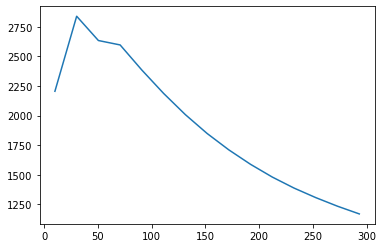

In [164]:
plt.plot(t_list, ys_list)